In [50]:
import astropy
import astropy.units as u
import numpy as np
import specutils
import matplotlib.pyplot as plt

import os

In [2]:
DJA_File_Path=os.path.expanduser('~/DJAData/')
if os.path.exists(DJA_File_Path):
    DJA_File_List=np.array(os.listdir(DJA_File_Path))
print('Number of files in DJA directory:', len(DJA_File_List))

Number of files in DJA directory: 18506


Processing file: goodsn-wide-v2_prism-clear_1211_6205.spec.fits


Set DATE-AVG to '2023-03-25T21:25:39.835' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to    15.371831 from OBSGEO-[XYZ].
Set OBSGEO-H to 1229294746.764 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


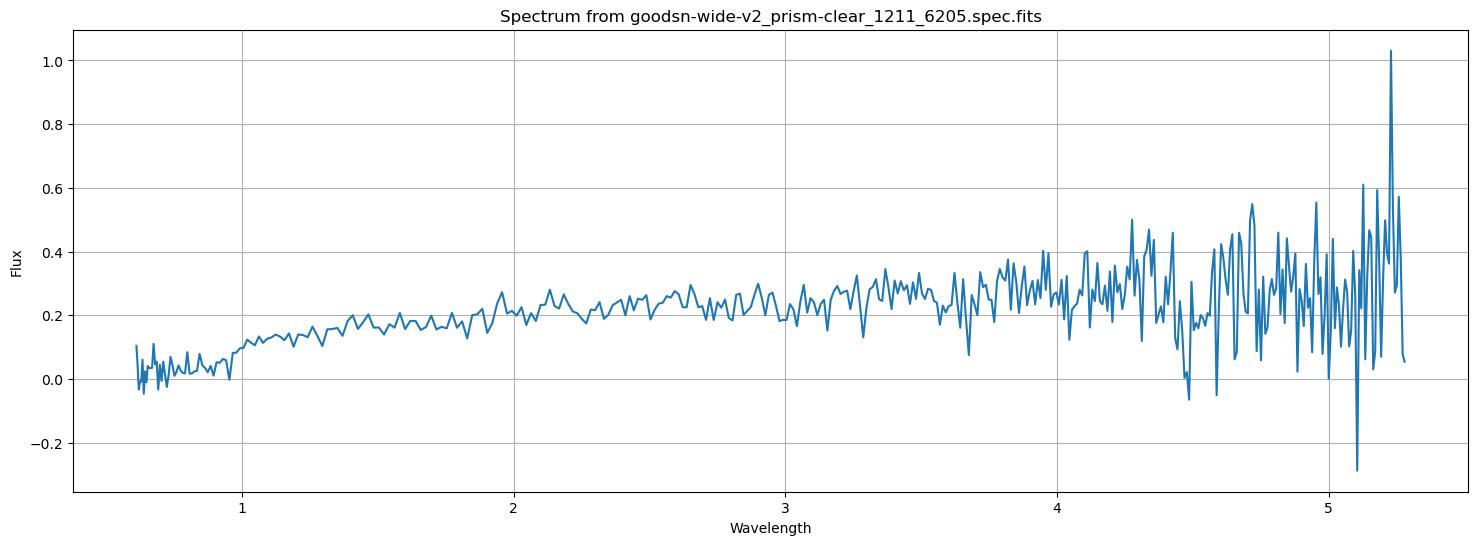

In [51]:
for file in DJA_File_List:
    if file.endswith('.fits'):
        print('Processing file:', file)
        # Load the spectrum
        spectrum = specutils.Spectrum1D.read(os.path.join(DJA_File_Path, file))

        # Plot the spectrum
        plt.figure(figsize=(18, 6))
        plt.plot(spectrum.spectral_axis, spectrum.flux)
        plt.title(f'Spectrum from {file}')
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.grid()
        plt.show()
        break
    else:
        print('Skipping non-FITS file:', file)

In [43]:
spectrum

<Spectrum1D(flux=[nan ... nan] uJy (shape=(435,), mean=0.21995 uJy); spectral_axis=<SpectralAxis [0.58       0.58368511 0.58743788 ... 5.3224998  5.32956424 5.33661817] um> (length=435); uncertainty=StdDevUncertainty)>

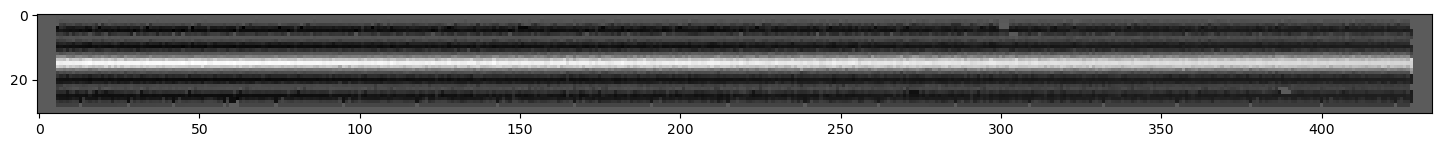

In [27]:
# Plot the third HDU
plt.figure(figsize=(18, 6))
plt.imshow(fits_hdulist[4].data, cmap='gray')

In [28]:
spec_1d=fits_hdulist[1].data

In [29]:
spec_1d

FITS_rec([(0.58      ,         nan,        inf),
          (0.58368511,         nan,        inf),
          (0.58743788,         nan,        inf),
          (0.59126022,         nan,        inf),
          (0.59515426,         nan,        inf),
          (0.59912194,         nan,        inf),
          (0.60316525,         nan, 0.04187486),
          (0.60728664,         nan, 0.02930017),
          (0.61148833,  0.10437698, 0.03379796),
          (0.61577259,  0.04200712, 0.02576688),
          (0.62014179, -0.0327998 , 0.03193506),
          (0.62459864, -0.00772454, 0.03216212),
          (0.62914577, -0.00839092, 0.0329687 ),
          (0.63378584,  0.06055541, 0.03371974),
          (0.63852165, -0.04627137, 0.02385586),
          (0.6433561 ,  0.02387315, 0.02348859),
          (0.6482922 , -0.01035949, 0.02205524),
          (0.65333313,  0.04085029, 0.03430349),
          (0.6584822 ,  0.03498675, 0.02532696),
          (0.66374277,  0.03388157, 0.02621404),
          (0.6691183

In [33]:
plt.figure(figsize=(18, 6))
plt.plot(spec_1d[0,:], spec_1d[1,:])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1800x600 with 0 Axes>

In [41]:
spec_1d[:][0]

(np.float64(0.58), np.float64(nan), np.float64(inf))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.table import Table
import glob
import os
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import line_flux, equivalent_width
from specutils.fitting import fit_lines
from specutils.manipulation import extract_region
from astropy.modeling import models
import warnings

# 忽略一些不必要的警告
warnings.filterwarnings('ignore', category=UserWarning)

# 定义Hα和Hβ的静止波长
HALPHA = 6562.8 * u.AA
HBETA = 4861.3 * u.AA

def load_fits_spectrum(file_path):
    """
    使用specutils从FITS文件加载光谱
    """
    print(f"读取文件: {file_path}")

    with fits.open(file_path) as hdul:
        # 查看FITS文件的结构
        print(f"FITS文件包含 {len(hdul)} 个HDU")

        # 假设主数据在第一个HDU，但可能需要根据实际文件调整
        flux = hdul[0].data
        header = hdul[0].header

        # 尝试从头文件中读取波长信息
        try:
            crval1 = header.get('CRVAL1', 0)
            cdelt1 = header.get('CDELT1', 1)
            naxis1 = header.get('NAXIS1', len(flux))

            # 创建波长数组
            wavelength = crval1 + np.arange(naxis1) * cdelt1
            wavelength = wavelength * u.AA  # 添加单位

            # 如果数据是多维的，提取一维光谱
            if flux.ndim > 1:
                print(f"检测到多维数据，形状: {flux.shape}")
                # 提取中心行作为光谱
                flux = flux[flux.shape[0]//2, :]

            # 创建specutils Spectrum1D对象
            uncertainty = StdDevUncertainty(np.sqrt(np.abs(flux)))
            spectrum = Spectrum1D(flux=flux * u.dimensionless_unscaled,
                                  spectral_axis=wavelength,
                                  uncertainty=uncertainty)

            return spectrum, header

        except Exception as e:
            print(f"从头文件中提取波长信息时出错: {e}")
            print("尝试使用备用方法...")

            # 如果无法从头文件获取波长，创建一个简单的波长数组
            if flux.ndim > 1:
                flux = flux[flux.shape[0]//2, :]

            wavelength = np.arange(len(flux)) * u.AA
            spectrum = Spectrum1D(flux=flux * u.dimensionless_unscaled,
                                 spectral_axis=wavelength)

            return spectrum, header

def find_line_center(spectrum, rest_wavelength, search_window=100*u.AA):
    """
    在给定波长附近查找发射线的确切位置
    """
    # 定义搜索区域
    search_region = SpectralRegion(rest_wavelength - search_window/2,
                                   rest_wavelength + search_window/2)

    try:
        # 提取该区域
        region_spectrum = extract_region(spectrum, search_region)

        # 找到最大通量的位置
        max_idx = np.argmax(region_spectrum.flux.value)
        line_center = region_spectrum.spectral_axis[max_idx]

        return line_center
    except Exception as e:
        print(f"查找线中心时出错: {e}")
        return rest_wavelength  # 返回静止波长作为默认值

def measure_emission_line(spectrum, line_center, window_width=20*u.AA):
    """
    测量发射线的通量和等效宽度
    """
    # 定义发射线区域
    line_region = SpectralRegion(line_center - window_width/2,
                                line_center + window_width/2)

    try:
        # 测量线通量
        flux_value = line_flux(spectrum, line_region)

        # 测量等效宽度
        ew_value = equivalent_width(spectrum, line_region)

        # 拟合高斯模型来获取更精确的结果
        g_init = models.Gaussian1D(amplitude=spectrum.flux.max(),
                                  mean=line_center,
                                  stddev=2*u.AA)
        g_fit = fit_lines(spectrum, g_init)

        # 提取拟合参数
        fitted_amplitude = g_fit.amplitude.value
        fitted_mean = g_fit.mean.value
        fitted_stddev = g_fit.stddev.value

        return {
            'flux': flux_value,
            'ew': ew_value,
            'amplitude': fitted_amplitude,
            'center': fitted_mean,
            'sigma': fitted_stddev,
            'line_region': line_region
        }
    except Exception as e:
        print(f"测量发射线参数时出错: {e}")
        return None

def plot_emission_line(spectrum, line_results, line_name, output_dir=None):
    """
    绘制发射线和拟合结果
    """
    if line_results is None:
        print(f"无法绘制{line_name}，没有有效的测量结果")
        return

    plt.figure(figsize=(10, 6))

    # 提取发射线区域
    line_region = line_results['line_region']
    region_spectrum = extract_region(spectrum, line_region)

    # 绘制观测数据
    plt.step(region_spectrum.spectral_axis.value,
             region_spectrum.flux.value,
             'b-', label='观测光谱')

    # 创建拟合模型
    x = region_spectrum.spectral_axis.value
    gaussian = models.Gaussian1D(
        amplitude=line_results['amplitude'],
        mean=line_results['center'],
        stddev=line_results['sigma']
    )
    plt.plot(x, gaussian(x), 'r--', label='高斯拟合')

    # 添加信息
    plt.axvline(x=line_results['center'], color='k', linestyle=':', label='线中心')

    plt.xlabel('波长 (Å)')
    plt.ylabel('通量')
    plt.title(f'{line_name} 发射线 (等效宽度: {line_results["ew"].value:.2f} Å)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f"{line_name.replace(' ', '_')}_fit.png"), dpi=150)

    plt.tight_layout()
    plt.show()

def plot_full_spectrum(spectrum, line_centers, specname, output_dir=None):
    """
    绘制完整光谱并标记发射线位置
    """
    plt.figure(figsize=(12, 6))

    # 绘制完整光谱
    plt.step(spectrum.spectral_axis.value, spectrum.flux.value)

    # 标记发射线位置
    line_names = ["Hα", "Hβ"]
    colors = ['r', 'g']

    for i, (center, name) in enumerate(zip(line_centers, line_names)):
        if center is not None:
            plt.axvline(x=center.value, color=colors[i], linestyle='--')
            ypos = spectrum.flux.max().value * 0.8
            plt.text(center.value, ypos, name, rotation=90, color=colors[i])

    plt.xlabel('波长 (Å)')
    plt.ylabel('通量')
    plt.title(f'光谱: {specname}')
    plt.grid(True, alpha=0.3)

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f"{specname}_full_spectrum.png"), dpi=150)

    plt.tight_layout()
    plt.show()

def main():
    """
    主函数：处理所有FITS文件并测量发射线
    """
    # 定义输出目录
    output_dir = "emission_line_results"
    os.makedirs(output_dir, exist_ok=True)

    # 获取所有FITS文件
    fits_files = glob.glob("*.fits")

    if not fits_files:
        print("当前目录中未找到FITS文件！")
        return

    # 创建结果表格
    results_table = Table(names=["文件名", "Hα流量", "Hα等效宽度", "Hβ流量", "Hβ等效宽度", "Hα/Hβ比率"],
                         dtype=["S30", float, float, float, float, float])

    for fits_file in fits_files:
        spec_name = os.path.basename(fits_file).split('.')[0]
        print(f"\n处理: {spec_name}")

        try:
            # 加载光谱
            spectrum, header = load_fits_spectrum(fits_file)

            # 查找发射线中心
            halpha_center = find_line_center(spectrum, HALPHA)
            hbeta_center = find_line_center(spectrum, HBETA)

            print(f"找到Hα位置: {halpha_center:.2f}")
            print(f"找到Hβ位置: {hbeta_center:.2f}")

            # 测量发射线
            halpha_results = measure_emission_line(spectrum, halpha_center)
            hbeta_results = measure_emission_line(spectrum, hbeta_center)

            # 绘制发射线拟合
            plot_emission_line(spectrum, halpha_results, "Halpha", output_dir)
            plot_emission_line(spectrum, hbeta_results, "Hbeta", output_dir)

            # 绘制完整光谱
            plot_full_spectrum(spectrum, [halpha_center, hbeta_center], spec_name, output_dir)

            # 计算Hα/Hβ比率
            if halpha_results and hbeta_results:
                halpha_flux = halpha_results['flux'].value
                hbeta_flux = hbeta_results['flux'].value
                ratio = halpha_flux / hbeta_flux if hbeta_flux > 0 else np.nan

                print(f"Hα流量: {halpha_flux:.4e}")
                print(f"Hβ流量: {hbeta_flux:.4e}")
                print(f"Hα/Hβ比率: {ratio:.2f}")

                # 添加到结果表格
                results_table.add_row([
                    spec_name,
                    halpha_flux,
                    halpha_results['ew'].value,
                    hbeta_flux,
                    hbeta_results['ew'].value,
                    ratio
                ])

        except Exception as e:
            print(f"处理{fits_file}时出错: {e}")

    # 保存结果表格
    if len(results_table) > 0:
        results_file = os.path.join(output_dir, "emission_line_measurements.csv")
        results_table.write(results_file, format='csv', overwrite=True)
        print(f"\n结果已保存到: {results_file}")

        # 打印结果表格
        print("\n========== 测量结果摘要 ==========")
        print(results_table)

if __name__ == "__main__":
    main()

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.table import Table

import glob
import os
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import line_flux, equivalent_width
from specutils.fitting import fit_lines
from specutils.manipulation import extract_region
from astropy.modeling import models
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

HALPHA_WAVELENGTH=6562.8*u.AA
HEBTA_WAVELENGTH=4861.3*u.AA

In [ ]:
def load_fits_spectrum(file_path):
    """
    Use Specutils to load spectrum from FITS files
    """

    with fits.open(file_path) as hdul:
        spectrum_1d=specutils.Spectrum1D.read(file_path)
    return 0

def find_line_centre(Specutils_spectrum,rest_frame_wavelength,redshift,search_window=100*u.AA):
    """
    Find the line centre corrosponding to the given wavelength from the input spectrum
    """

    observed_wavelength = rest_frame_wavelength * (1 + redshift)

    search_region=SpectralRegion(observed_wavelength - search_window/2,
                                 observed_wavelength + search_window/2)

    try:
        
